In [1]:
import extract_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from scipy.signal import filtfilt, butter, iirnotch, welch
import math
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
data, words, starts, ends = extract_data.extract_data(r"C:\Users\lwing\Downloads\College\Spring 2022\Senior Design II\SilentSpeechDAS\EMGData\Vocal_full_6.txt", r"C:\Users\lwing\Downloads\College\Spring 2022\Senior Design II\silent-speech\scripts\Vocal_Full_6.txt")

2022-03-28T16:09:40.388-05


In [3]:
chan_1 = data[:,0]
chan_2 = data[:,1]
chan_3 = data[:,2]
chan_4 = data[:,3]
chan_5 = data[:,4]
chan_6 = data[:,5]
channel_data = [chan_1, chan_2, chan_3, chan_4, chan_5, chan_6]

### Creating target variable list

In [4]:
len(chan_1)

672750

In [5]:
y = np.zeros(672750)

In [6]:
print(starts)
print(ends)

[ 14155  21206  27792  34166  41035  47522  53987  60401  67260  73897
  80426  86928  93350 100149 106804 113274 119678 126180 132687 139212
 145587 152008 158617 165323 172208 178784 185265 191793 198256 204708
 211207 217957 224467 230939 237441 244005 250507 257115 263832 270458
 276824 283573 290689 297296 304002 310696 317264 323621 330116 336835
 343239 349963 356575 363243 369750 376709 383482 390194 396616 403269
 409748 416283 423111 429485 436060 442663 449281 455864 462264 468952
 475605 482272 488945 495603 502327 508744 515809 522566 529489 535940
 542343 548910 555354 562086 568609 574859 581446 588060 594618 601201
 607950 614491 621285 627779 634706 641621 648545 655619 662426]
[ 15654  22248  28590  35450  41976  48487  54953  61653  68326  74828
  81371  87775  94560 101232 107686 114169 120543 127118 133732 140062
 146530 152997 159761 166528 173255 179711 186178 192768 199182 205700
 212415 218982 225459 231927 238526 244944 251612 258229 264824 271363
 277928 2850

In [7]:
for i in range(len(starts)):
    y[starts[i]:ends[i]+1] = 1

In [8]:
print(np.count_nonzero(y))

104691


In [9]:
len(y)

672750

### Filtering

In [10]:
# [Band Pass to demonstrate most prominent frequency range]
low_cutoff = 20
high_cutoff = 450

filtered_data = [0,0,0,0,0,0]

for idx, channel in enumerate(channel_data):
    signal_meancorrect = channel - np.mean(channel)
    
    #60Hz Notch Filter for Power Line Noise
    b, a = iirnotch(60, 30, 1000)
    signal_notched = filtfilt(b, a, signal_meancorrect)

    # Fourth Order Butterworth 
    b, a = butter(10, [low_cutoff, high_cutoff], fs=1000, btype='bandpass')
    signal_filtered = filtfilt(b, a, signal_notched)

    #Rectify signal
    filtered_data[idx] = abs(signal_filtered)

In [11]:
print(chan_1)
print(filtered_data[0])

[-0.02555129 -0.0287452  -0.02235738 ... -0.16608337 -0.19163466
 -0.24912506]
[0.00027324 0.00318481 0.00313431 ... 0.06567007 0.0463265  0.00107387]


### RMS

In [12]:
rms_window = deque([0,0,0,0,0])

for channel in filtered_data:
    for i, sample in enumerate(channel):
        rms_window.popleft()
        rms_window.append(sample)
        val = np.sqrt(sum(np.square(rms_window)/5))
        channel[i] = val

In [13]:
print(filtered_data[0])

[0.0001222  0.00142952 0.00200208 ... 0.06531884 0.06714348 0.06269261]


### Deleting extraneous data

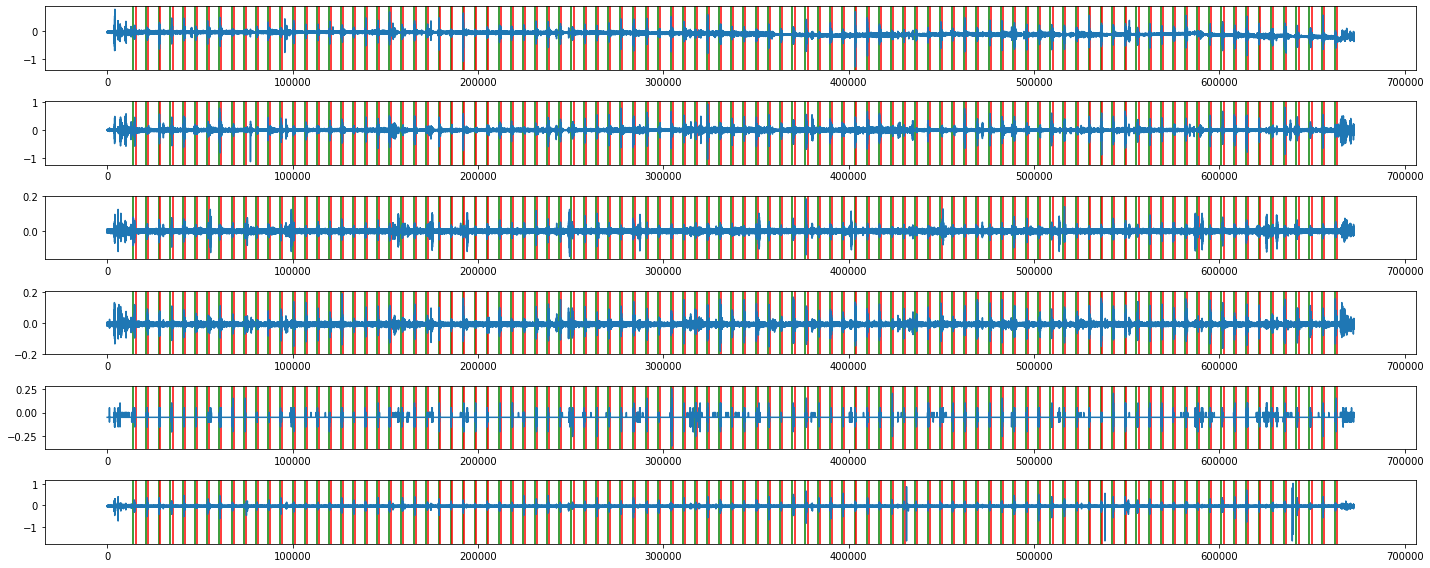

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from extract_data import extract_data



plt.figure(figsize=(20,8))
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.plot(data[:,i]); plt.ylim(plt.ylim())
    plt.vlines(starts,-2,2,'g'); plt.vlines(ends,-2,2,'r')

plt.tight_layout()
plt.show()

In [15]:
#deleting indices :14155, 663372:

for i in range(len(filtered_data)):
    filtered_data[i] = filtered_data[i][14155:663372]

In [16]:
len(filtered_data[0])

649217

In [17]:
y = y[14155:663372]

In [18]:
 #large window to average over
window = 40
        
        #overlap interval
skip = 20
        
ind1 = 0
ind2 = window
y_new = np.zeros(int(len(y)/20)+1)
i = 0
while ind1 < len(y):
            
    #remaining data less than window size, avoid array out of bounds
    if ind2 > len(y):
        ind2 = len(y)
                
    num_label = np.count_nonzero(y[ind1:ind2])
    if num_label > 19:
        y_new[i] = 1
    ind1 = ind1 + skip
    ind2 = ind2 + skip
    i = i+1

In [19]:
print(len(y))
print(len(y_new))

649217
32461


### Smoothing data as described by SAD doc

In [20]:
def smooth(raw):
        
    #large window to average over
    window = 40
        
    #overlap interval
    skip = 20
        
    ind1 = 0
    ind2 = window
    copy = np.copy(np.array(raw))
    new = np.zeros(int(len(raw)/20)+1)
    i = 0
    while ind1 < len(raw):
            
        #remaining data less than window size, avoid array out of bounds
        if ind2 > len(raw):
            ind2 = len(raw)
                
        val = np.mean(copy[ind1:ind2], dtype=np.float64)
        new[i] = val
            
            
        ind1 = ind1 + skip
        ind2 = ind2 + skip
        i = i+1
    return new
    
def calculate(smoothed_envelope):
        
    return np.abs(np.diff(smoothed_envelope))

In [21]:
ready_data = [0,0,0,0,0,0]

for i in range(len(filtered_data)):
    res = smooth(filtered_data[i])
    ready_data[i] = calculate(res)

In [22]:
print(np.count_nonzero(ready_data[0]))

32460


In [23]:
len(ready_data[0])

32460

In [24]:
y_new = y_new[:32460]
print(len(y_new))

32460


In [25]:
print(np.count_nonzero(y_new))

5237


### Making dataframe and prepping for decision tree classifier

In [26]:
df = pd.DataFrame({
    
    "Chan1": ready_data[0],
    "Chan2": ready_data[1],
    "Chan3": ready_data[2],
    "Chan4": ready_data[3],
    "Chan5": ready_data[4],
    "Chan6": ready_data[5],
    "Y": y_new 
})

In [27]:
X = df[['Chan1', 'Chan2', 'Chan3', 'Chan4', 'Chan5', 'Chan6']]
Y = df[['Y']]

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [30]:
print(len(X_train))
print(len(X_test))


25968
6492


In [31]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
print(clf.score(X_test, y_test))

0.8877079482439926


In [33]:
print(np.mean(cross_val_score(clf, X_train, y_train)))

0.8917516330186196


In [34]:
predicted = clf.predict(X_test)

#I obtain the accuracy of this fold
ac=accuracy_score(predicted,y_test)
print(ac)
#I obtain the confusion matrix
cm=confusion_matrix(y_test, predicted)
print(cm)



0.8877079482439926
[[5014  397]
 [ 332  749]]


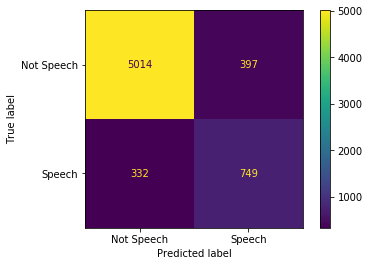

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cmd = ConfusionMatrixDisplay(cm,display_labels=['Not Speech','Speech'])
cmd.plot()